# Imbalanced Dataset Performance (UNSW-NB15)

In [14]:
# Data Handling & Preprocessing
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# Training
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Visualization & Debugging
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preparation
The dataset I'm using is UNSW-NB15, the data already split so I don't need to split it manually. The dataset is divided into:
- Training-set with CSV format.
- Testing-set with CSV format.

Load the Dataset

In [2]:
# Load CSV files
df_train = pd.read_csv('UNSW_NB15_training-set.csv')
df_test = pd.read_csv('UNSW_NB15_testing-set.csv')

# Display the first 5 rows
df_train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


Check class distribution and answer this question:
- What are the minority attack classes?
- How severe is the imbalance?

In [3]:
# Check column names
print(df_train.columns)
print("-----------------------------------")

# Count occurences of each unieque value in the attack_cat column
print(df_train["attack_cat"].value_counts())
print("-----------------------------------")
print(df_test["attack_cat"].value_counts())

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')
-----------------------------------
attack_cat
Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: count, dtype: int64
-----------------------------------
attack_cat
Normal            37000
Generic           188

In [4]:
# Drop rows where 'attack_cat' is 'Normal'
df_train_attack = df_train[df_train['attack_cat'] != 'Normal']
df_test_attack = df_test[df_test['attack_cat'] != 'Normal']

# Count occurences of each attack classes
print(df_train_attack["attack_cat"].value_counts())
print("-----------------------------------")
print(df_test_attack["attack_cat"].value_counts())

attack_cat
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: count, dtype: int64
-----------------------------------
attack_cat
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: count, dtype: int64


Visualize the Class Imbalance

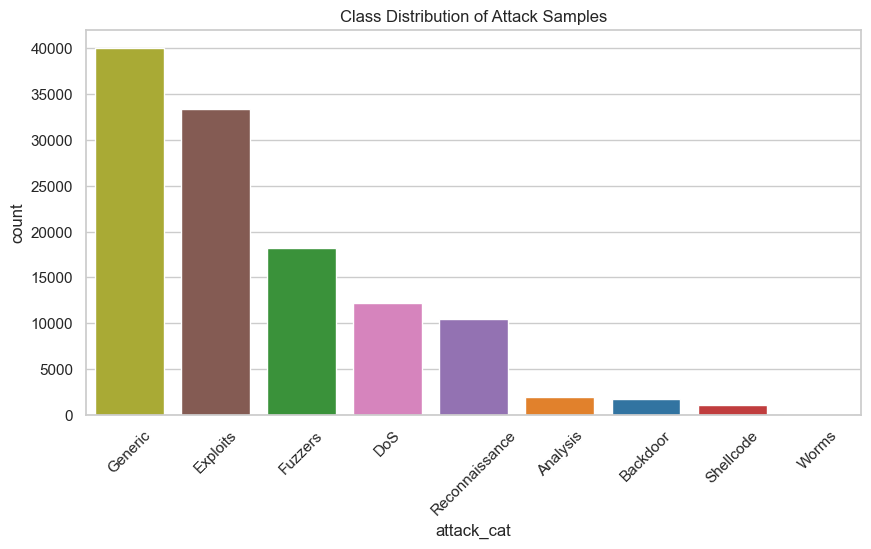

In [5]:
plt.figure(figsize=(10, 5))
sns.set_theme(style="whitegrid")
sns.countplot(data=df_train_attack, 
              x="attack_cat", 
              order=df_train_attack['attack_cat'].value_counts().index, 
              hue="attack_cat", 
              palette="tab10", 
              legend=False)
plt.xticks(rotation=45)
plt.title('Class Distribution of Attack Samples')
plt.show()

To measure how severe the imbalance is, I'm use imbalance ratio (IR) and other statistical metrics.
The imbalance ratio (IR) tells us how imbalanced the dataset is. It’s calculated as:

IR = Majority class count / Minority class count

- If IR > 1.5, the dataset is imbalanced.  
- If IR > 10, the imbalance is severe.  
- If any class has less than 5% of the dataset, which indicates a significant imbalance.

In [6]:
# Find the majority and minority class sizes
class_counts = df_train_attack['attack_cat'].value_counts()
majority_class = class_counts.max()
minority_class = class_counts.min()

# Compute imbalance ratio
imbalance_ratio = majority_class / minority_class
print(f"Imbalance Ratio (IR): {imbalance_ratio:.2f}\n")

# Compute percentage distribution
total_samples = len(df_train_attack)
percentages = (class_counts / total_samples) * 100
print(percentages)

Imbalance Ratio (IR): 307.69

attack_cat
Generic           33.517400
Exploits          27.981163
Fuzzers           15.237010
DoS               10.276435
Reconnaissance     8.790776
Analysis           1.675870
Backdoor           1.463034
Shellcode          0.949380
Worms              0.108932
Name: count, dtype: float64


The answer above question is:
- There is few minority attack classes **less then 5%** of the dataset here: Worms, Shellcode, Backdoor, and Analysis.
- The Imbalance Ratio is 307.69 which indicate the dataset is **highly imbalance!**.

Encode Feature (type=object)

In [7]:
print(df_train_attack.dtypes)
print(df_test_attack.dtypes)

id                     int64
dur                  float64
proto                 object
service               object
state                 object
spkts                  int64
dpkts                  int64
sbytes                 int64
dbytes                 int64
rate                 float64
sttl                   int64
dttl                   int64
sload                float64
dload                float64
sloss                  int64
dloss                  int64
sinpkt               float64
dinpkt               float64
sjit                 float64
djit                 float64
swin                   int64
stcpb                  int64
dtcpb                  int64
dwin                   int64
tcprtt               float64
synack               float64
ackdat               float64
smean                  int64
dmean                  int64
trans_depth            int64
response_body_len      int64
ct_srv_src             int64
ct_state_ttl           int64
ct_dst_ltm             int64
ct_src_dport_l

In [8]:
le = LabelEncoder()

df_corr = df_train_attack.copy(deep=True)

#Encode state, service, proto
df_corr['state'] = le.fit_transform(df_corr['state'])
df_corr['service'] = le.fit_transform(df_corr['service'])
df_corr['proto'] = le.fit_transform(df_corr['proto'])
df_corr['attack_cat'] = le.fit_transform(df_corr['attack_cat'])

df_corr.dtypes

id                     int64
dur                  float64
proto                  int64
service                int64
state                  int64
spkts                  int64
dpkts                  int64
sbytes                 int64
dbytes                 int64
rate                 float64
sttl                   int64
dttl                   int64
sload                float64
dload                float64
sloss                  int64
dloss                  int64
sinpkt               float64
dinpkt               float64
sjit                 float64
djit                 float64
swin                   int64
stcpb                  int64
dtcpb                  int64
dwin                   int64
tcprtt               float64
synack               float64
ackdat               float64
smean                  int64
dmean                  int64
trans_depth            int64
response_body_len      int64
ct_srv_src             int64
ct_state_ttl           int64
ct_dst_ltm             int64
ct_src_dport_l

Feature Selection  
Use Correlation to know how strong between feature

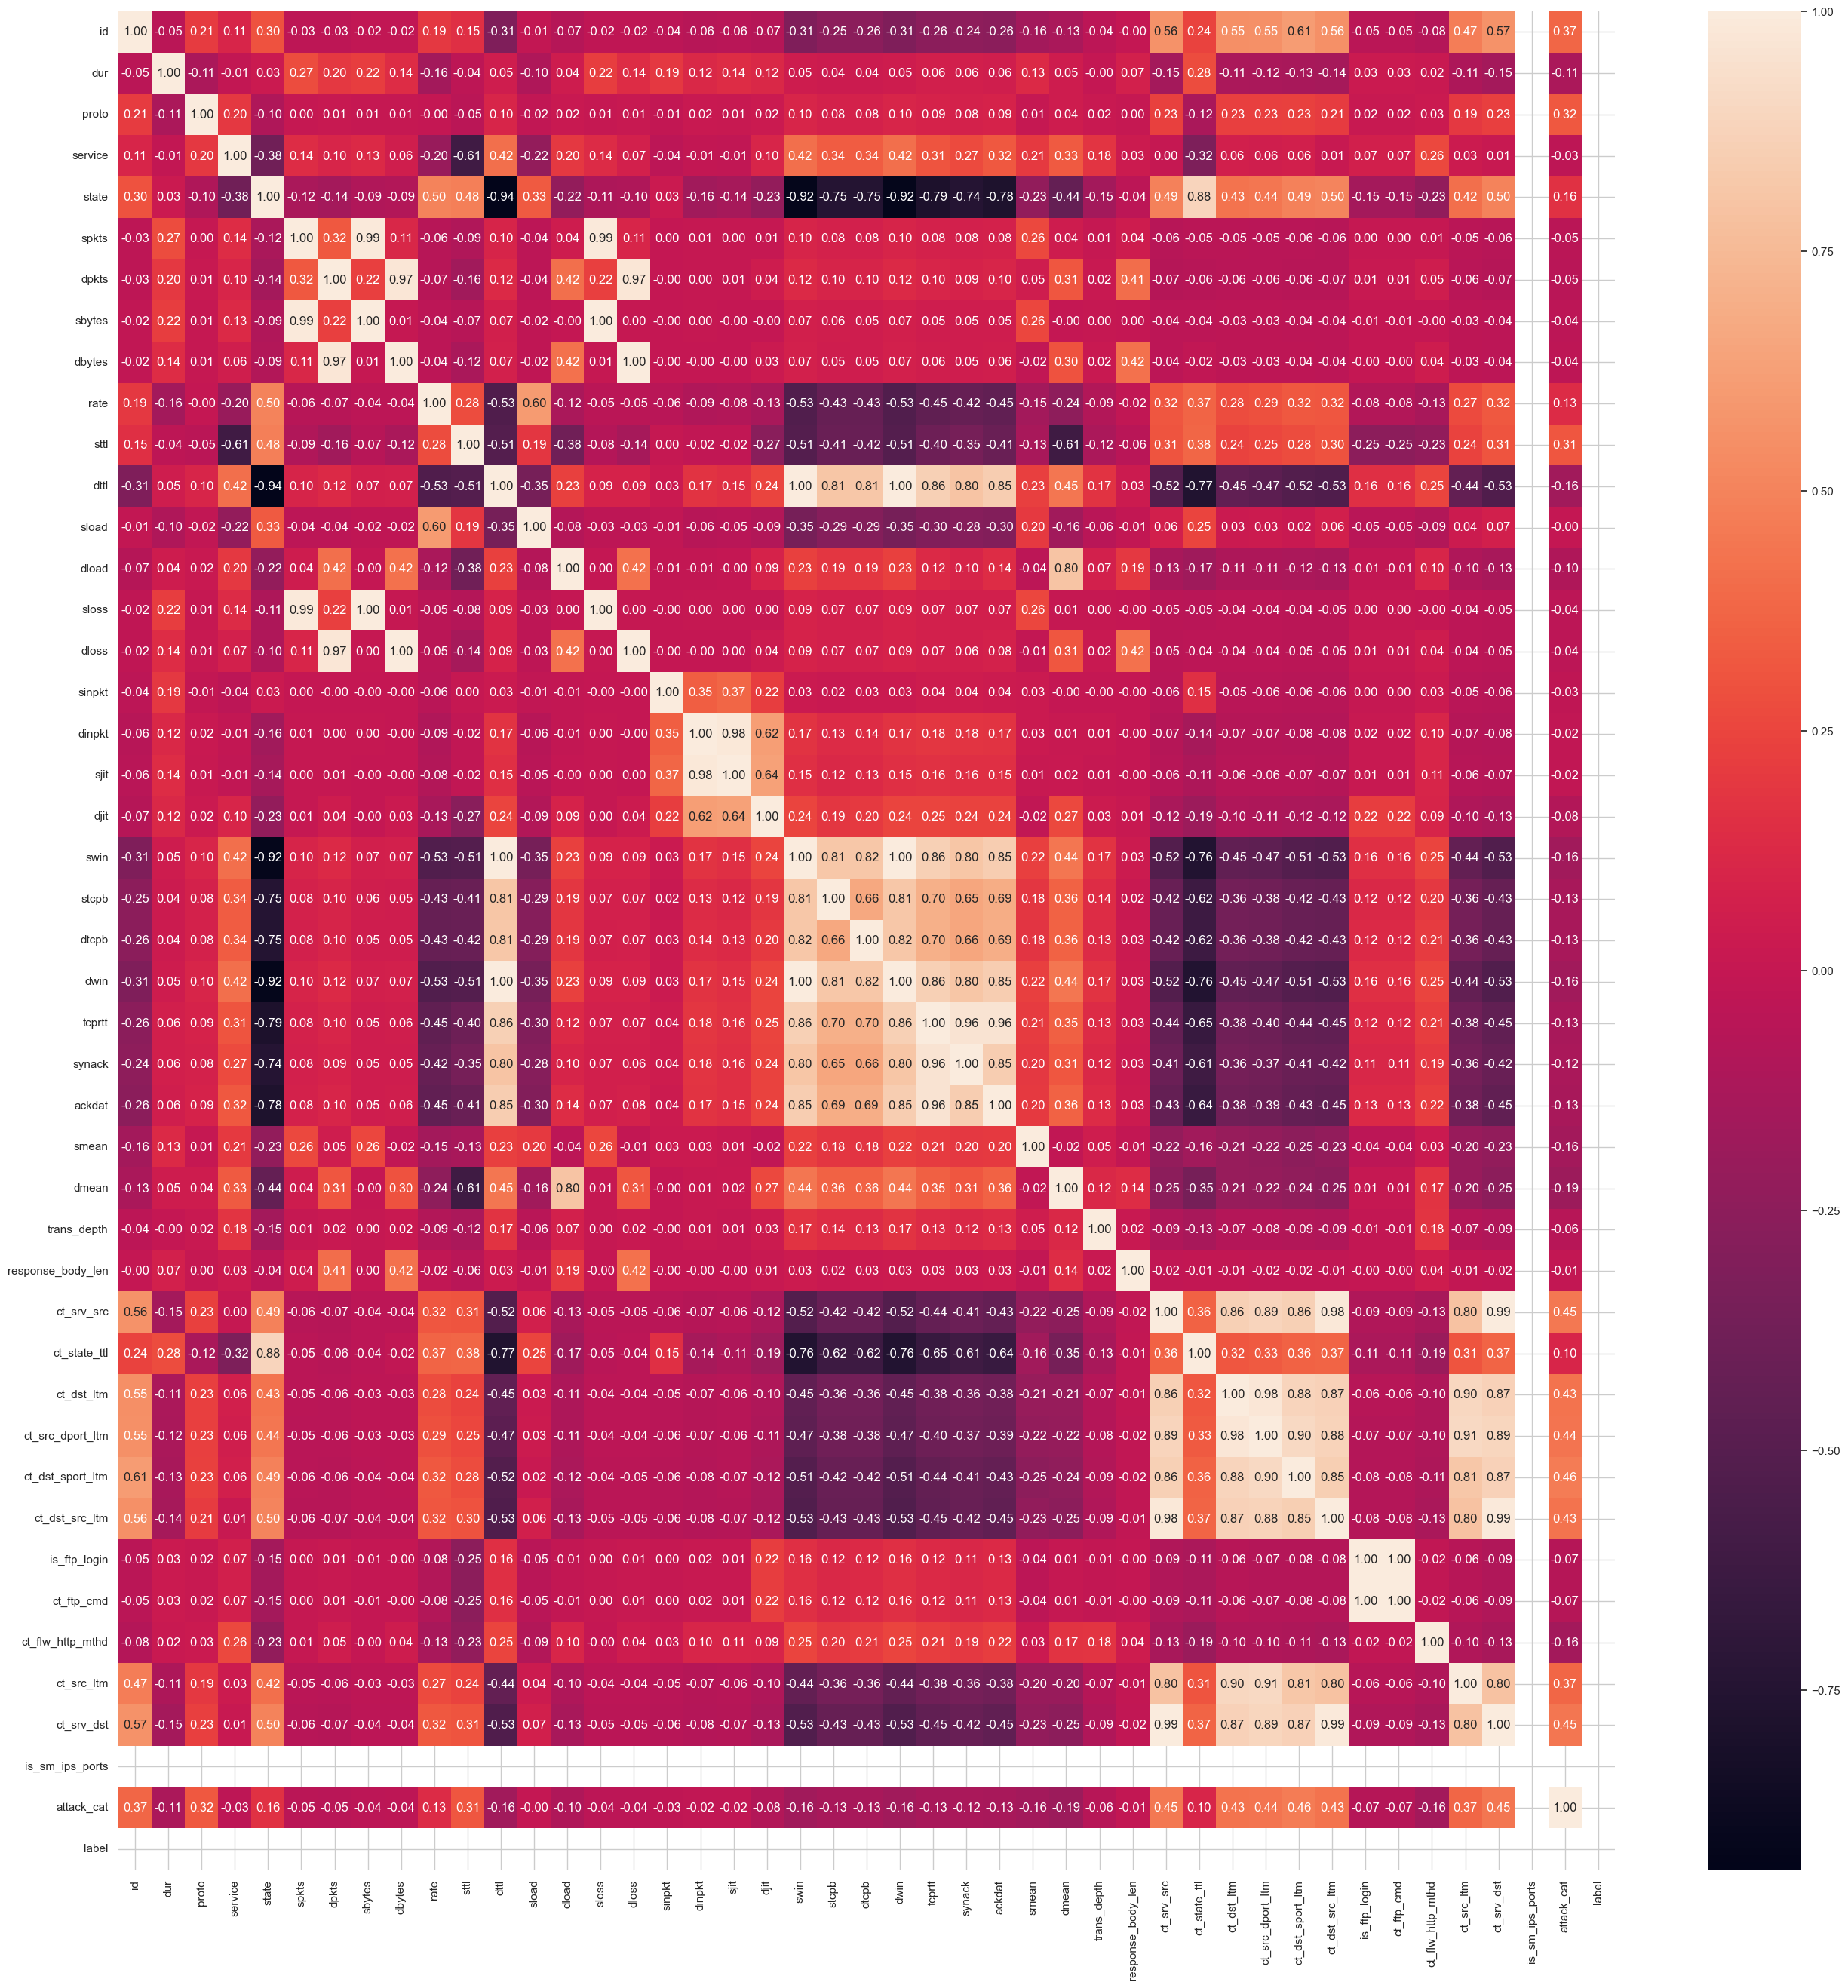

In [9]:
#Correlation between feature
plt.figure(figsize=[32,32])
sns.heatmap(df_corr.corr(), annot=True, fmt=".2f")
plt.show()

Normalize Features

In [10]:
# Drop unnecessary columns first
df_train_attack.drop(columns=['id', 'label', 'dinpkt', 'ct_ftp_cmd', 'is_sm_ips_ports'], inplace=True)
df_test_attack.drop(columns=['id', 'label', 'dinpkt', 'ct_ftp_cmd', 'is_sm_ips_ports'], inplace=True)

# Encode state, service, proto (train and test data)
df_train_attack['state'] = le.fit_transform(df_train_attack['state'])
df_train_attack['service'] = le.fit_transform(df_train_attack['service'])
df_train_attack['proto'] = le.fit_transform(df_train_attack['proto'])

df_test_attack['state'] = le.fit_transform(df_test_attack['state'])
df_test_attack['service'] = le.fit_transform(df_test_attack['service'])
df_test_attack['proto'] = le.fit_transform(df_test_attack['proto'])

# Select only numerical features
numerical_cols = df_train_attack.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Apply MinMaxScalar to normalize the numerical features
scaler = MinMaxScaler()
df_train_attack[numerical_cols] = scaler.fit_transform(df_train_attack[numerical_cols])
df_test_attack[numerical_cols] = scaler.fit_transform(df_test_attack[numerical_cols])

C:\Users\Acer\AppData\Local\Temp\ipykernel_12436\463448947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_attack.drop(columns=['id', 'label', 'dinpkt', 'ct_ftp_cmd', 'is_sm_ips_ports'], inplace=True)
C:\Users\Acer\AppData\Local\Temp\ipykernel_12436\463448947.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_attack.drop(columns=['id', 'label', 'dinpkt', 'ct_ftp_cmd', 'is_sm_ips_ports'], inplace=True)
C:\Users\Acer\AppData\Local\Temp\ipykernel_12436\463448947.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [11]:
# Display the first 5 rows
df_train_attack.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,attack_cat
47911,1.500024e-07,0.148438,0.0,0.5,0.000104,0.0,0.000011,0.0,0.111111,0.996078,...,0.333333,0.00,0.00,0.000000,0.046875,0.0,0.0,0.016949,0.058824,Backdoor
47912,1.500024e-07,0.390625,0.0,0.5,0.000104,0.0,0.000011,0.0,0.111111,0.996078,...,0.333333,0.02,0.02,0.033333,0.093750,0.0,0.0,0.016949,0.117647,Backdoor
47913,1.500024e-07,0.085938,0.0,0.5,0.000104,0.0,0.000011,0.0,0.111111,0.996078,...,0.333333,0.00,0.00,0.000000,0.078125,0.0,0.0,0.000000,0.098039,Backdoor
47914,5.000080e-08,0.968750,0.0,0.5,0.000104,0.0,0.000011,0.0,0.333333,0.996078,...,0.333333,0.02,0.02,0.033333,0.093750,0.0,0.0,0.016949,0.098039,Backdoor
47915,1.333355e-07,0.656250,0.0,0.5,0.000104,0.0,0.000011,0.0,0.125000,0.996078,...,0.333333,0.00,0.00,0.000000,0.046875,0.0,0.0,0.169492,0.058824,Backdoor


In [12]:
# Display the first 5 rows
df_test_attack.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,attack_cat
243,1.536657e-02,0.585938,0.0,0.8,0.001785,0.0,0.000087,0.0,0.000021,0.996078,...,0.333333,0.000000,0.0,0.0,0.016129,0.0,0.0,0.0,0.0,Reconnaissance
244,1.536657e-02,0.585938,0.0,0.8,0.001785,0.0,0.000087,0.0,0.000021,0.996078,...,0.333333,0.000000,0.0,0.0,0.016129,0.0,0.0,0.0,0.0,Reconnaissance
245,1.536657e-02,0.585938,0.0,0.8,0.001785,0.0,0.000087,0.0,0.000021,0.996078,...,0.333333,0.000000,0.0,0.0,0.016129,0.0,0.0,0.0,0.0,Backdoor
246,1.536657e-02,0.585938,0.0,0.8,0.001785,0.0,0.000087,0.0,0.000021,0.996078,...,0.333333,0.000000,0.0,0.0,0.016129,0.0,0.0,0.0,0.0,DoS
247,1.500012e-07,0.726562,0.0,0.8,0.000094,0.0,0.000006,0.0,0.111111,0.996078,...,0.333333,0.017241,0.0,0.0,0.016129,0.0,0.0,0.0,0.0,Exploits


In [13]:
# Separate features and labels for training set
X = df_train_attack.drop(columns=["attack_cat"])  # Features
y = df_train_attack["attack_cat"]  # Labels

# Ensure test set is prepared correctly
X_test = df_test_attack.drop(columns=["attack_cat"])
y_test = df_test_attack["attack_cat"]

# Split into train (70%) and validation (30%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Data preparation complete!")
print(f"Training set: {X_train.shape}\nValidation set: {X_val.shape}\nTesting set: {X_test.shape}")

Data preparation complete!
Training set: (83538, 39)
Validation set: (35803, 39)
Testing set: (45332, 39)


## **Train Machine Learning Models**
- Choose models for evaluation:
  - **XGBoost**
  - **Random Forest** (Baseline)
  - **Neural Networks (MLPClassifier)**
- Train each model using the **imbalanced dataset**.

In [15]:
# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

# Train the XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train_enc)

# Predict on validation set
y_val_pred = xgb_model.predict(X_val)

# Evaluate the XGBoost model
accuracy = accuracy_score(y_val_enc, y_val_pred)
print(f'XGBoost Validation Accuracy: {accuracy:.2f}')
print(f'\nXGBoost Classification Report:\n', classification_report(y_val_enc, y_val_pred, target_names=le.classes_))
print('\nXGBoost Confusion Matrix:\n', confusion_matrix(y_val_enc, y_val_pred))

XGBoost Validation Accuracy: 0.81

XGBoost Classification Report:
                 precision    recall  f1-score   support

      Analysis       0.78      0.24      0.37       600
      Backdoor       0.77      0.12      0.21       524
           DoS       0.40      0.14      0.20      3679
      Exploits       0.63      0.91      0.75     10018
       Fuzzers       0.96      0.89      0.93      5455
       Generic       1.00      0.98      0.99     12000
Reconnaissance       0.92      0.75      0.83      3148
     Shellcode       0.68      0.77      0.73       340
         Worms       0.52      0.31      0.39        39

      accuracy                           0.81     35803
     macro avg       0.74      0.57      0.60     35803
  weighted avg       0.81      0.81      0.79     35803


XGBoost Confusion Matrix:
 [[  147    11    46   395     1     0     0     0     0]
 [   10    64    47   389     5     0     4     5     0]
 [    3     1   498  3088    27     9    20    33     0]
 [ 

In [19]:
# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_enc)

# Predict on validation set
y_val_pred_rf = rf_model.predict(X_val)

# Evaluate the Random Forest model
rf_accuracy = accuracy_score(y_val_enc, y_val_pred_rf)
print(f'Random Forest Validation Accuracy: {accuracy:.2f}')
print(f'\nRandom Forest Classification Report:\n', classification_report(y_val_enc, y_val_pred_rf, target_names=le.classes_))
print('\nRandom Forest Confusion Matrix:\n', confusion_matrix(y_val_enc, y_val_pred_rf))

Random Forest Validation Accuracy: 0.81

Random Forest Classification Report:
                 precision    recall  f1-score   support

      Analysis       0.78      0.24      0.36       600
      Backdoor       0.70      0.14      0.23       524
           DoS       0.31      0.23      0.27      3679
      Exploits       0.64      0.83      0.73     10018
       Fuzzers       0.95      0.89      0.92      5455
       Generic       1.00      0.98      0.99     12000
Reconnaissance       0.93      0.74      0.83      3148
     Shellcode       0.70      0.67      0.68       340
         Worms       0.55      0.15      0.24        39

      accuracy                           0.80     35803
     macro avg       0.73      0.54      0.58     35803
  weighted avg       0.80      0.80      0.79     35803


Random Forest Confusion Matrix:
 [[  142    18   112   323     5     0     0     0     0]
 [   12    71   125   298    10     0     3     5     0]
 [    0     2   862  2736    28     6    1

In [18]:
# Train the MLPClassifier model
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train_enc)

# Predict on validation set
y_val_pred_mlp = mlp_model.predict(X_val)

# Evaluate the MLPClassifier model
mlp_accuracy = accuracy_score(y_val_enc, y_val_pred_mlp)
print(f'MLPClassifier Validation Accuracy: {accuracy:.2f}')
print(f'\nMLPClassifier Classification Report:\n', classification_report(y_val_enc, y_val_pred_mlp, target_names=le.classes_))
print('\nMLPClassifier Confusion Matrix:\n', confusion_matrix(y_val_enc, y_val_pred_mlp))

MLPClassifier Validation Accuracy: 0.81

MLPClassifier Classification Report:
                 precision    recall  f1-score   support

      Analysis       0.71      0.21      0.33       600
      Backdoor       0.64      0.03      0.07       524
           DoS       0.41      0.13      0.20      3679
      Exploits       0.62      0.89      0.73     10018
       Fuzzers       0.91      0.87      0.89      5455
       Generic       1.00      0.98      0.99     12000
Reconnaissance       0.83      0.75      0.79      3148
     Shellcode       0.58      0.53      0.55       340
         Worms       0.88      0.18      0.30        39

      accuracy                           0.80     35803
     macro avg       0.73      0.51      0.54     35803
  weighted avg       0.79      0.80      0.77     35803


MLPClassifier Confusion Matrix:
 [[  127     2    42   426     3     0     0     0     0]
 [    0    18    60   412    10     0    18     6     0]
 [    3     2   479  3065    61     6    3

## **Step 3: Evaluate Model Performance**
- Use the **testing set** to evaluate trained models.
- Compute performance metrics:
  - **Accuracy**
  - **Precision, Recall, F1-score**
  - **Confusion Matrix**
  - **AUC-ROC Curve**
- Compare results to assess improvement.

## **Step 4: Model Validation**
- Perform **Cross-validation** on the training set.
- Conduct **Hyperparameter tuning** (GridSearchCV, RandomizedSearchCV).
- Check for **overfitting/underfitting**.

## **Step 5: Conclusion**
- Summarize model performances.
- Identify the best-performing model for **network intrusion detection**.
- Discuss whether **balancing improved model performance**.